<a href="https://colab.research.google.com/github/Jinukki/KJU/blob/master/seq2seqemid2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### 앞서 배운 seq2seq 모델은 인코더에서 입력 시퀀스를 컨텍스트 벡터라는 하나의 고정된 크기의 벡터 표현으로 압축하고, 디코더는 이 컨텍스트 벡터를 통해서 출력 시퀀스를 만들어냈다.

##### 하지만 이러한 RNN에 기반한 seq2seq 모델에는 크게 두 가지 문제가 있다.<br>
첫째, 하나의 고정된 크기의 벡터에 모든 정보를 압축하려고 하니까 정보 손실이 발생한다.<br>
둘째, RNN의 고질적인 문제인 기울기 소실(Vanishing Gradient) 문제가 존재한다.

##### 즉, 결국 이는 기계 번역 분야에서 입력 문장이 길면 번역 품질이 떨어지는 현상으로 나타났다. 이를 위한 대안으로 입력 시퀀스가 길어지면 출력 시퀀스의 정확도가 떨어지는 것을 보정해주기 위한 등장한 기법인 어텐션(attention)을 소개할 것이다.

> ##### 어텐션의 아이디어
##### 어텐션의 기본 아이디어는 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 인코더에서의 전체 입력 문장을 다시 한 번 참고한다는 점이다. 단, 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, 해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 집중(attention)해서 보게 된다.

##### 어텐션 모델은 처음에는 sequence to sequence context vector 를 개선하기 위하여 제안되었지만, 이제는 다양한 딥러닝 모델링에 하나의 기술로 이용되고 있다. 물론 모델의 성능을 향상 시킨 점도 크지만, 부산물로 얻을 수 있는 attention weight matrix 를 이용한 모델의 작동 방식에 대한 시각화는 모델의 안정성을 점검하고, 모델이 의도와 다르게 작동할 때 그 원인을 찾는데 이용될 수 있다. 이전보다 쉽게 복잡한 모델들을 해석할 수 있게 된 것이다.

###### 아래 그림처럼 디코더 RNN이 $y_i$를 선택할 때 encoder RNN의 $h_j$를 얼만큼 이용할지를 $a_ij$로 정의한다. $a_ij$를 attention weight 라 하며, 이 역시 neural network 에 의하여 학습된다.

![어텐션 1](https://user-images.githubusercontent.com/52277776/70718298-4e27f300-1d33-11ea-93cd-a740587edb97.png)

##### 즉 이전에는 아래의 그림처럼 ‘this is example sentence’ 를 ‘이것은 예문이다’로 번역하기 위하여 매번 같은 context vector 를 이용했지만, 

![어텐션 2](https://user-images.githubusercontent.com/52277776/70718308-5122e380-1d33-11ea-80c2-891304cdf872.png)

##### attention 이 이용되면서 ‘이것’ 이라는 단어를 선택하기 위하여 ‘this is’ 라는 부분에 주목할 수 있게 되었다.

![어텐션 3](https://user-images.githubusercontent.com/52277776/70718314-52eca700-1d33-11ea-96ad-347ceffd9c9d.png)

##### 그리고 그 결과물로 attention weight matrix 를 얻을 수 있다. 아래는 영어와 프랑스어 간에 번역을 위하여 각각 어떤 단어끼리 높은 attention weight 가 부여됬는지를 표현한 그림이다. 검정색일수록 낮은 weight 를 의미한다. 관사끼리는 서로 연결이 되어 있으며, 의미가 비슷한 단어들이 실제로 높은 attention weight 를 얻는다. 그리고 하나의 단어가 두 개 이상의 단어의 정보를 조합하여 이용하기도 한다.

##### 하지만 대체로 한 단어 $y_i$를 만들기 위하여 이용되는 $h_j$ 의 개수는 그리 많지 않다. 이는 decoder 가 context 를 선택적으로 이용하고 있다는 의미이다. 그럼에도 불구하고 기존의 sequence to sequence 에서는 하나의 벡터에 이 모든 정보를 표현하려 했으니, RNN 의 모델의 크기는 커야했고 성능도 낮을 수 밖에 없었다. Attention mechanism 은 같은 크기의 공간을 이용하는 RNN 이라면 더 좋은 성능을 보이도록 도와주었다. RNN 은 sequence encoding 을, attention 은 context vector 를 만드는 일을 서로 나눴다. 하나의 네트워크에 하나의 일만 맡기는 것은 네트워크에 부하를 줄여주는 것이다.

---
##### 단뱡항 LSTM으로 텍스트 분류를 수행할 수도 있지만 때로는 양방향 LSTM을 사용하는 것이 더 강력하다. 여기에 추가적으로 어텐션 메커니즘을 사용할 수도 있다. 양방향 LSTM과 어텐션 메커니즘으로 지난 발표에서 진행했던 IMDB 리뷰 감성 분류하기를 수행해 보자.

In [1]:
try:

    %tensorflow_version 2.x  # %tensorflow_version only exists in Colab

except Exception:

    pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # %tensorflow_version only exists in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
vocab_size = 10000 # 최대 단어 개수 100개
# 훈련데이터와 테스트데이터 받아오기
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)

In [21]:
# 패딩을 위한 리뷰의 최대 길이와 평균길이 확인
print('리뷰의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


In [0]:
# 평균길이보도 조금 더 크게 패딩
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

##### 이제 어텐션 메커니즘을 적용해 보자. 다시 말하자면 RNN의 모든 은닉 상태들을 다시 한 번 참고하겠다는 것이다. 그리고 이를 위해서 어텐션 메커니즘을 사용한다.

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, BatchNormalization
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [0]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # warining 표시 안나오도록 하기

In [0]:
# 입력층과 임베딩층 설계
sequence_input = Input(shape=(max_len,), dtype='int32')
# 10,000개의 단어들을 128차원의 임베딩 벡터로 임베딩하도록 설계
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len)(sequence_input)

In [0]:
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
    (LSTM(128, dropout=0.3, return_sequences=True, return_state=True, recurrent_activation='relu', recurrent_initializer='glorot_uniform'))(embedded_sequences)

##### 양방향 LSTM을 설계하였다. 순방향 LSTM의 은닉 상태와 셀상태를 forward_h, forward_c에 저장하고, 역방향 LSTM의 은닉 상태와 셀 상태를 backward_h, backward_c에 저장합니다. 양방향 LSTM을 사용할 경우에는 순방향 LSTM과 역방향 LSTM 각각 은닉 상태와 셀 상태를 가지므로, 양방향 LSTM의 은닉 상태와 셀 상태를 사용하려면 두 방향의 LSTM의 상태들을 연결(concatenate)해주면 된다.

In [0]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [0]:
attention = BahdanauAttention(128) # 가중치 크기 정의
# 어텐션 매커니즘에서는 은닉 상태 사용, 이를 입력으로 컨텍스트 벡터 얻음
context_vector, attention_weights = attention(lstm, state_h)

In [0]:
attention = BahdanauAttention(128) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

In [0]:
hidden = BatchNormalization()(context_vector)

In [0]:
# 이진출력이므로 Dense에 1개의 층 & 시그모이드 활성화 함수 사용
output = Dense(1, activation='sigmoid')(hidden)
model = Model(inputs=sequence_input, outputs=output)

In [0]:
Adam = optimizers.Adam(lr=0.0001, clipnorm=1.)

In [0]:
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 291s 12ms/sample - loss: 0.4526 - accuracy: 0.7898 - val_loss: 0.3946 - val_accuracy: 0.8408
Epoch 2/10
25000/25000 [==============================] - 291s 12ms/sample - loss: nan - accuracy: 0.6140 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/10
25000/25000 [==============================] - 289s 12ms/sample - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/10
25000/25000 [==============================] - 293s 12ms/sample - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/10
25000/25000 [==============================] - 293s 12ms/sample - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 6/10
25000/25000 [==============================] - 291s 12ms/sample - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/10
25000/25000 [==============================] - 292s 12ms/sample

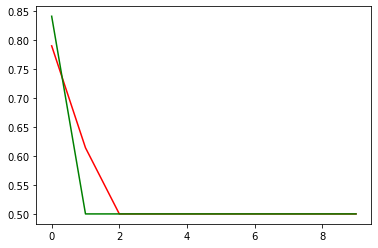

In [42]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='green')
plt.show()